Metrics by Model for benchmark 'speech-tag':
      model  tests compliant  system_compliant  rules_system_with_input_compliant
llama3.2:1b             37.0         37.166667                          11.666667


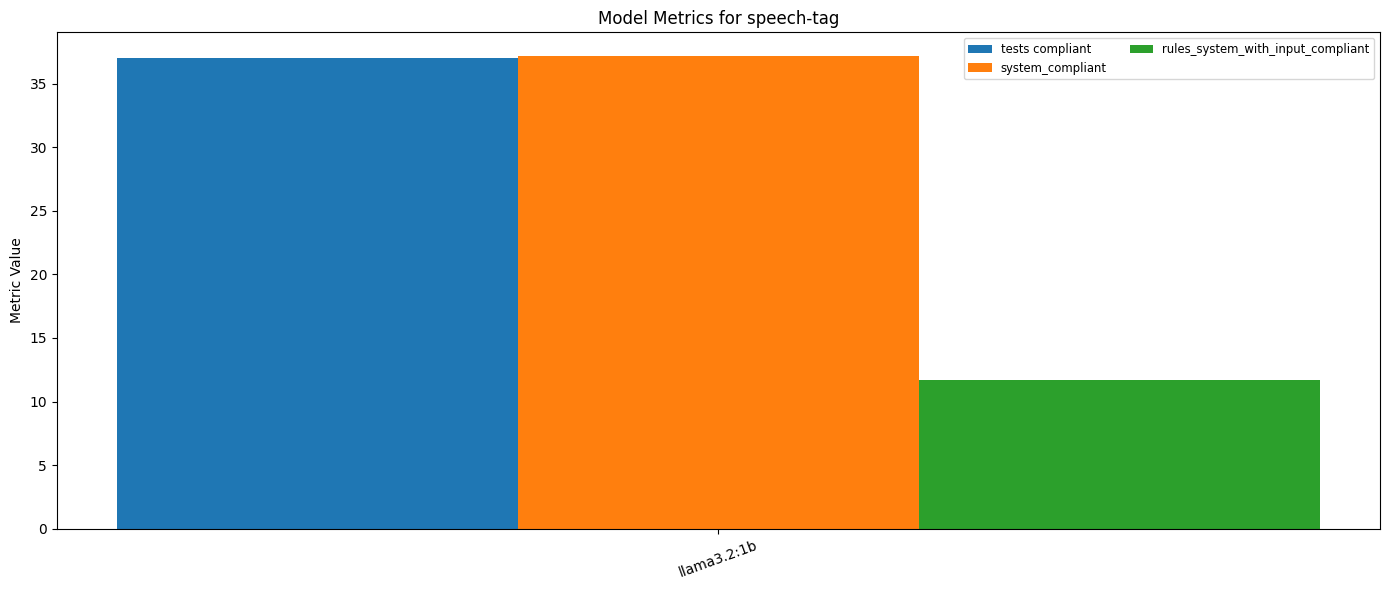

In [24]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

benchmarkVersion = "test-all-2025-05-16"

rootDir = "/workspaces/promptpex/"

if not os.path.isdir(rootDir):
    rootDir = ".."

evalsDir = f'{rootDir}/evals/{benchmarkVersion}/'

# full list
benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", "shakespearean-writing-assistant"]

benchmarks = [
    "speech-tag", "elements",  "text-to-p"
]

prettyNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}

def analyze_benchmark_metrics(benchmark, evalsDir, prettyNames):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Build the path to the overview.csv for the given benchmark
    csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")

    # Read the CSV
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Strip whitespace from column names

    # Find the index of the 'tests valid compliant' column
    start_col = df.columns.get_loc('tests valid compliant') + 1

    # Include "tests compliant" as a metric (ensure it's included)
    metrics = ['tests compliant'] + list(df.columns[start_col:])

    # Extract model names and metrics columns
    models = df['model']
    metrics_table = df[['model'] + metrics].copy()

    # Convert percentage strings and NaN to float, treat NaN as 0
    def parse_metric(val):
        if isinstance(val, str) and val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        try:
            v = float(val)
            if np.isnan(v):
                return 0.0
            return v
        except:
            return 0.0

    for metric in metrics:
        metrics_table[metric] = metrics_table[metric].apply(parse_metric)

    print(f"Metrics by Model for benchmark '{benchmark}':")
    print(metrics_table.to_string(index=False))

    # Plot grouped bar chart
    x = np.arange(len(models))
    width = 0.8 / len(metrics)  # total width for all bars per group

    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, metrics_table[metric], width, label=metric)

    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Metric Value')
    ax.set_title(f"Model Metrics for {prettyNames.get(benchmark, benchmark)}")
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# Example usage:
analyze_benchmark_metrics("speech-tag", evalsDir, prettyNames)

Average Metrics by Model:
Model	rules_system_with_input_compliant	system_compliant	tests compliant
llama3.2:1b	15.45	40.92	22.33


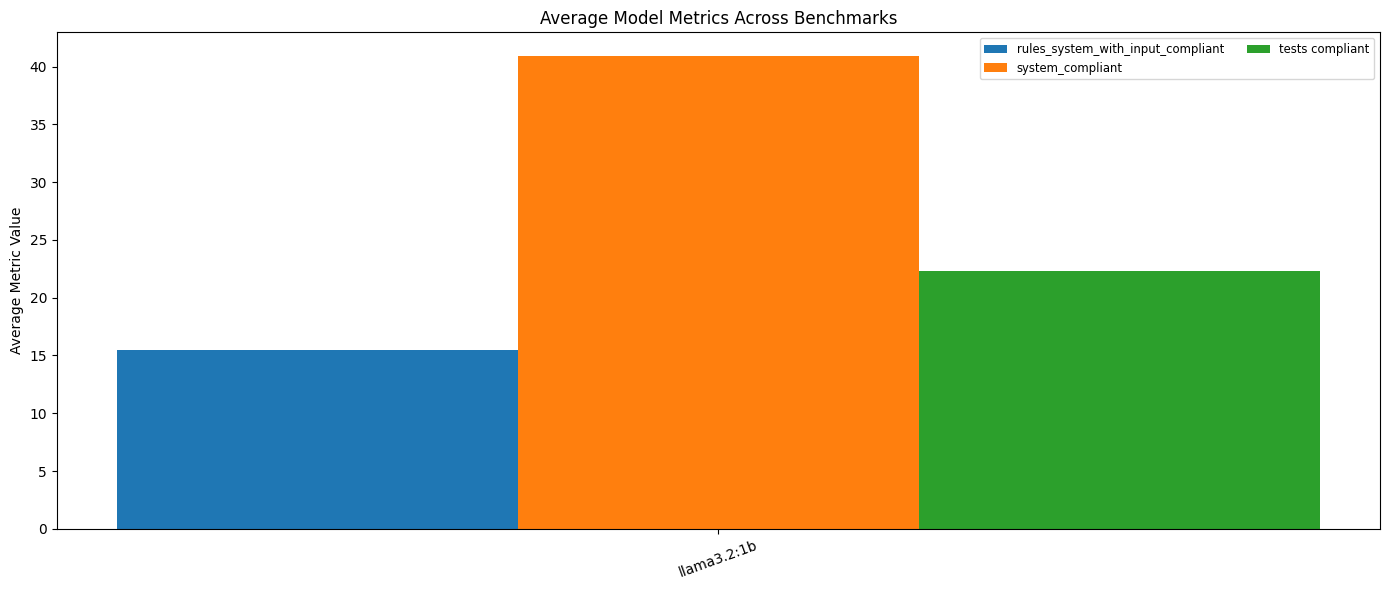

In [25]:
def parse_metric(val):
    """Convert metric to float, handle %, NaN, and '--'."""
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        if val in ('NaN', '--', ''):
            return 0.0
    try:
        v = float(val)
        if np.isnan(v):
            return 0.0
        return v
    except:
        return 0.0

def collect_metrics(benchmarks, evalsDir):
    # Data structure: {benchmark: {model: {metric: value}}}
    all_data = {}
    all_metrics = set()
    all_models = set()

    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        # Find metrics columns
        start_col = df.columns.get_loc('tests valid compliant') + 1
        metrics = ['tests compliant'] + list(df.columns[start_col:])
        all_metrics.update(metrics)
        all_data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            all_models.add(model)
            all_data[benchmark].setdefault(model, {})
            for metric in metrics:
                all_data[benchmark][model][metric] = parse_metric(row[metric])
    return all_data, sorted(all_models), sorted(all_metrics)

def compute_model_metric_averages(all_data, all_models, all_metrics):
    # {model: {metric: [values...]}}
    model_metric_values = {model: {metric: [] for metric in all_metrics} for model in all_models}
    for benchmark in all_data:
        for model in all_models:
            model_metrics = all_data[benchmark].get(model, {})
            for metric in all_metrics:
                val = model_metrics.get(metric, 0.0)
                model_metric_values[model][metric].append(val)
    # Compute averages
    model_metric_avg = {model: {metric: np.mean(vals) for metric, vals in metrics.items()} for model, metrics in model_metric_values.items()}
    return model_metric_avg

def print_metric_table(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    print("Average Metrics by Model:")
    header = ["Model"] + metrics
    print("\t".join(header))
    for model in models:
        row = [model] + [f"{model_metric_avg[model][metric]:.2f}" for metric in metrics]
        print("\t".join(row))

def plot_grouped_bar_chart(model_metric_avg):
    models = list(model_metric_avg.keys())
    metrics = list(next(iter(model_metric_avg.values())).keys())
    x = np.arange(len(models))
    width = 0.8 / len(metrics)
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(metrics):
        values = [model_metric_avg[model][metric] for model in models]
        ax.bar(x + i*width, values, width, label=metric)
    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=20)
    ax.set_ylabel('Average Metric Value')
    ax.set_title('Average Model Metrics Across Benchmarks')
    ax.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()



all_data, all_models, all_metrics = collect_metrics(benchmarks, evalsDir)
model_metric_avg = compute_model_metric_averages(all_data, all_models, all_metrics)
print_metric_table(model_metric_avg)
plot_grouped_bar_chart(model_metric_avg)

In [33]:
def print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest):
    import os
    import pandas as pd

    header = ["Benchmark", "Model"] + columns_of_interest
    print("\t".join(header))
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        for _, row in df.iterrows():
            model = row['model']
            values = []
            for col in columns_of_interest:
                val0 = row.get(col, 0)
                val = parse_metric(val0)
                values.append(f"{val:.2f}")
            print("\t".join([benchmark, model] + values))

# read csv for first benchmark
csv_path = os.path.join(evalsDir, benchmarks[0], benchmarks[0], "overview.csv")
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
start_col = df.columns.get_loc('tests valid compliant') + 1
# columns_of_interest = ["tests", "tests compliant", "errors", "tests compliance unknown"] + list(df.columns[start_col:])
columns_of_interest = ["tests compliant"] + list(df.columns[start_col:])

print_benchmark_model_metrics_table(benchmarks, evalsDir, columns_of_interest)

Benchmark	Model	tests compliant	system_compliant	rules_system_with_input_compliant
speech-tag	llama3.2:1b	37.00	37.17	11.67
elements	llama3.2:1b	27.00	64.88	31.25
text-to-p	llama3.2:1b	3.00	20.72	3.43


Benchmark	errors	tests compliance unknown
speech-tag	0.00	2.00
elements	0.00	0.00
text-to-p	0.00	0.00


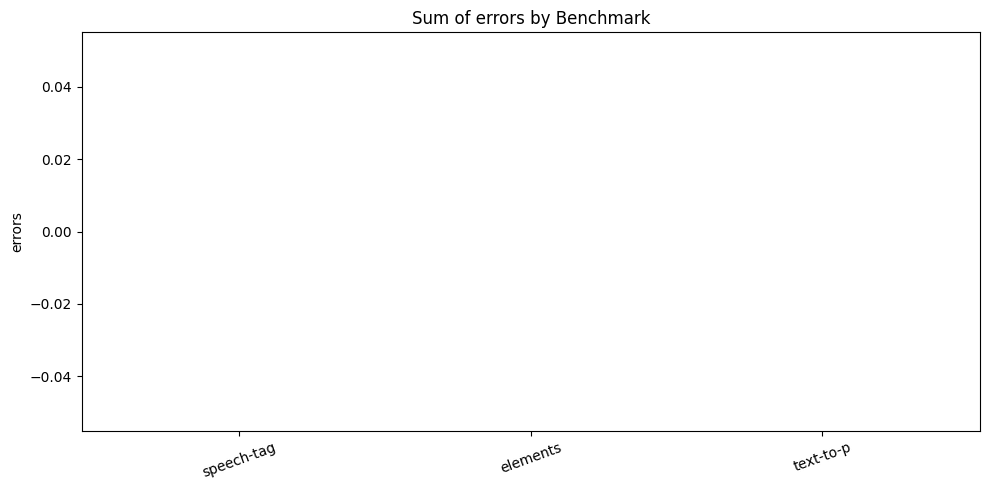

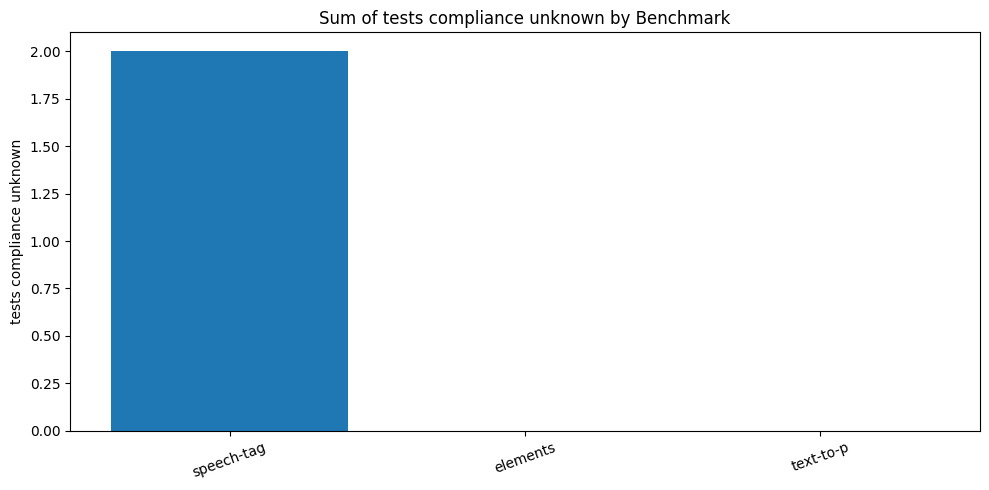

In [14]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_metric(val):
    """Convert metric to float, handle %, NaN, '--', and empty."""
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        if val in ('NaN', '--', ''):
            return 0.0
    try:
        v = float(val)
        if np.isnan(v):
            return 0.0
        return v
    except:
        return 0.0

def collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest):
    # data[benchmark][model][column]
    data = {}
    sums = {bench: {col: 0.0 for col in columns_of_interest} for bench in benchmarks}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        data[benchmark] = {}
        for _, row in df.iterrows():
            model = row['model']
            data[benchmark][model] = {}
            for col in columns_of_interest:
                val = parse_metric(row.get(col, 0))
                data[benchmark][model][col] = val
                sums[benchmark][col] += val
    return data, sums

def print_sums_table(sums, columns_of_interest):
    print("Benchmark\t" + "\t".join(columns_of_interest))
    for bench, colvals in sums.items():
        row = [bench] + [f"{colvals[col]:.2f}" for col in columns_of_interest]
        print("\t".join(row))

def plot_sums_bar(sums, columns_of_interest):
    benchmarks = list(sums.keys())
    for col in columns_of_interest:
        values = [sums[bench][col] for bench in benchmarks]
        plt.figure(figsize=(10, 5))
        plt.bar(benchmarks, values)
        plt.ylabel(col)
        plt.title(f"Sum of {col} by Benchmark")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

# Example usage:
benchmarks = [
    "speech-tag", "elements", "text-to-p"
]
evalsDir = "/home/zorn/promptpex/evals/test-all-2025-05-15-3app"
columns_of_interest = ["errors", "tests compliance unknown"]

data, sums = collect_and_sum_benchmark_metrics(benchmarks, evalsDir, columns_of_interest)
print_sums_table(sums, columns_of_interest)
plot_sums_bar(sums, columns_of_interest)

Benchmark	Average Tests per Model
speech-tag	96.00
text-to-p	88.00


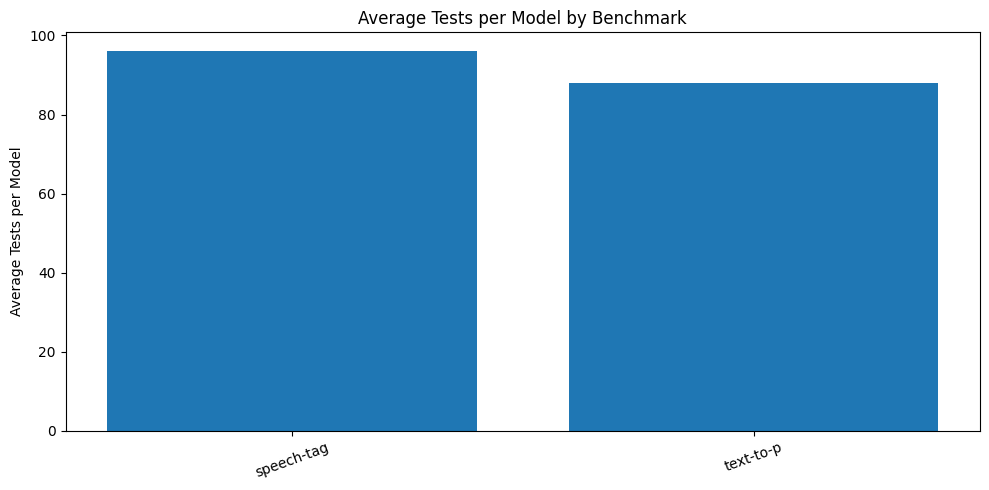

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_metric(val):
    """Convert metric to float, handle %, NaN, '--', and empty."""
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('%'):
            try:
                return float(val.strip('%'))
            except:
                return 0.0
        if val in ('NaN', '--', ''):
            return 0.0
    try:
        v = float(val)
        if np.isnan(v):
            return 0.0
        return v
    except:
        return 0.0

def average_tests_per_model(benchmarks, evalsDir):
    averages = {}
    for benchmark in benchmarks:
        csv_path = os.path.join(evalsDir, benchmark, benchmark, "overview.csv")
        if not os.path.isfile(csv_path):
            print(f"Warning: {csv_path} not found, skipping.")
            continue
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()
        # Parse the 'tests' column for all models
        tests = df['tests'].apply(parse_metric)
        if len(tests) > 0:
            avg = np.mean(tests)
        else:
            avg = 0.0
        averages[benchmark] = avg
    return averages

def print_avg_table(averages):
    print("Benchmark\tAverage Tests per Model")
    for bench, avg in averages.items():
        print(f"{bench}\t{avg:.2f}")

def plot_avg_bar(averages):
    benchmarks = list(averages.keys())
    values = list(averages.values())
    plt.figure(figsize=(10, 5))
    plt.bar(benchmarks, values)
    plt.ylabel("Average Tests per Model")
    plt.title("Average Tests per Model by Benchmark")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()



averages = average_tests_per_model(benchmarks, evalsDir)
print_avg_table(averages)
plot_avg_bar(averages)